In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Copy the uploaded zip file in google drive to colab session for faster processing.
!cp -r '/content/drive/My Drive/notebooks/images/fundus/Disease Grading.zip' '/'
!cp -r '/content/drive/My Drive/notebooks/images/fundus/hed_pretrained_bsds.caffemodel' '/'
!cp -r '/content/drive/My Drive/notebooks/images/fundus/deploy.prototxt' '/'
#Unzip the data in  colab session for faster processing.
!unzip '/Disease Grading.zip' -d '/'

Archive:  /Disease Grading.zip
   creating: /B. Disease Grading/
   creating: /B. Disease Grading/1. Original Images/
   creating: /B. Disease Grading/1. Original Images/a. Training Set/
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_001.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_002.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_003.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_004.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_005.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_006.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_007.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_008.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Training Set/IDRiD_009.jpg  
 extracting: /B. Disease Grading/1. Original Images/a. Tr

In [3]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import backend as K
import tensorflow as tf

#using tensor flow 2.x
tf.random.set_seed(30)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.python.keras import optimizers, losses, activations, models
from tensorflow.python.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.python.keras import applications

import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
import pandas as pd
import random as rn

import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
rn.seed(30)
tf.__version__

'2.4.1'

In [4]:
y = 150  # height of the image
z = 150  # Width of the image
clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(32,32))

horizontal_datagen = ImageDataGenerator(horizontal_flip=True)

def load_train_dataset(source_path,image_data):

  ls = len(image_data)

  train_img,train_label = list(),list()

  for index in range(ls):
    
    image_path = source_path+image_data[index][0]+".jpg"
    label = image_data[index][3]
    img = cv2.imread(image_path)
    img = cv2.resize(img, (z,y), interpolation=cv2.INTER_LINEAR)

    train_img.append(img)  
    train_label.append(label)
    # convert to numpy array
    
    if label == 0:
      data = img_to_array(img)
      # expand dimension to one sample
      samples = expand_dims(data, 0)
      # create image data augmentation generator

      it = horizontal_datagen.flow(samples, batch_size=1)
      batch = it.next()
        
      # convert to unsigned integers for viewing
      image = batch[0].astype('uint8')
      train_img.append(image)  
      train_label.append(label)

  
  temp = list(zip(train_img, train_label)) 
  rn.shuffle(temp) 
  train_img, train_label = zip(*temp) 
  return train_img,train_label

def load_test_dataset(source_path,image_data):

  ls = len(image_data)

  test_img,test_label = list(),list()

  for index in range(ls):
    
    image_path = source_path+image_data[index][0]+".jpg"
    label = image_data[index][3]

    img = cv2.imread(image_path)
    img = cv2.resize(img, (z,y), interpolation=cv2.INTER_LINEAR)
    test_img.append(img)  
    test_label.append(label)   

  temp = list(zip(test_img, test_label)) 
  rn.shuffle(temp) 
  test_img, test_label = zip(*temp)
  return test_img,test_label

#batch  generator
def generator(source_path, batch_size,image_data,label_data):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)

    ls = len(image_data)

    t = image_data
    num_batches = ls // batch_size;
    while True:        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,1)) # batch_labels is the one hot representation of the output
            
            for index in range(batch_size): # iterate over the batch_size
                               
                #image_path = source_path+t[(batch_size*batch) + index][0]+".jpg"             
                #print("reading train :: ",image_path)  
                #org_image =  cv2.imread(image_path) # read all the images in the folder
                
                org_image = image_data[(batch_size*batch) + index]
                #org_image = cv2.resize(org_image, (z,y), interpolation=cv2.INTER_LINEAR)

                h, w, c = org_image.shape
                if (h < y) or (w < z):
                  print(org_image.shape)
                #org_image_gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
                #final_image = clahe.apply(org_image_gray)
                #final_image = cv2.medianBlur(final_image,3)                    
                #final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)    

                final_image = (org_image / 127.5) - 1.0 

                batch_data[index,:,:,0] = final_image[:,:,0]
                batch_data[index,:,:,1] = final_image[:,:,1]
                batch_data[index,:,:,2] = final_image[:,:,2]

                
                batch_labels[index, 0] = label_data[(batch_size*batch) + index]
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        #Check if there are any remaining folders to be processed
        if len(t) % batch_size != 0 : 
            start = (batch_size*num_batches)
            end = len(t)
            batch_data = np.zeros((end-start,y,z,3))
            batch_labels = np.zeros((end-start,1))
            for index,id in enumerate(range(start , end)): # iterate over the batch_size
                
                
                #image_path =  source_path+imahe_data[id][0]+".jpg"    
                   
                #org_image =  cv2.imread(image_path) # read all the images in the folder

                org_image = image_data[id]
                #org_image = cv2.resize(org_image, (z,y), interpolation=cv2.INTER_LINEAR)

                h, w, c = org_image.shape
                if (h < y) or (w < z):
                  print(org_image.shape)
                #org_image_gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
                #final_image = clahe.apply(org_image_gray)
                #final_image = cv2.medianBlur(final_image,3)                    
                #final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)      
                
                final_image = (org_image / 127.5) - 1.0 

                batch_data[index,:,:,0] = final_image[:,:,0]
                batch_data[index,:,:,1] = final_image[:,:,1]
                batch_data[index,:,:,2] = final_image[:,:,2]

                batch_labels[index, 0] = label_data[id]      

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do       

In [5]:
batch_size = 32
num_epochs = 50
lr_factor=1e-5

train_source_path = '/B. Disease Grading/1. Original Images/a. Training Set/'
test_source_path = '/B. Disease Grading/1. Original Images/b. Testing Set/'

df_train = pd.read_csv('/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',usecols=['Image name',	'Retinopathy grade',	'Risk of macular edema '])
df_train['dr'] = [1 if x > 0 else 0 for x in df_train['Retinopathy grade']] 

df_test = pd.read_csv('/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',usecols=['Image name',	'Retinopathy grade',	'Risk of macular edema '])
df_test['dr'] = [1 if x > 0 else 0 for x in df_test['Retinopathy grade']] 

train_img,train_l = load_train_dataset(train_source_path,df_train.to_numpy())

test_img, test_l = load_test_dataset(test_source_path,df_test.to_numpy())


train_generator = generator(train_source_path ,batch_size,train_img,train_l)
val_generator = generator(test_source_path,batch_size,test_img,test_l)

In [6]:
print(train_l)

(1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


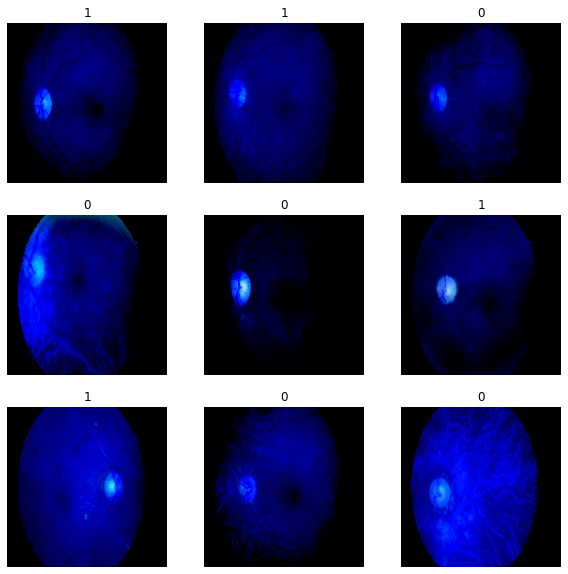

In [7]:
import numpy as np
images, labels = next(train_generator)
   
plt.figure(figsize=(10, 10))

for i in range(9):
    first_image = images[i]
    img = ((first_image * 127.5)+1).astype(np.int32)
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = data_augmentation(
    #    tf.expand_dims(first_image, 0), training=True
    #)
    plt.imshow(first_image)
    plt.title(int(labels[i]))
    plt.axis("off")

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
#norm_layer = keras.layers.experimental.preprocessing.Normalization()
#mean = np.array([127.5] * 3)
#ar = mean ** 2
# Scale inputs to [-1, +1]
#x = norm_layer(x)
#norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [10]:
num_train_sequences = len(train_img)
num_val_sequences = len(test_img)

#CALCULATE NUMBER OF STEPS IN EACH EPOCH
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

curr_dt_time = datetime.datetime.now()
#CREATE CHECKPOINT TO STORE THE BEST MODEL
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
  
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor="val_loss", mode="max", patience=50)

#CREATE DECAY RATE OPTIMIZATION
#https://keras.io/callbacks/
LR = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR, early]



model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=2e-4, momentum=0.9),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 100
model.fit(train_generator, epochs=epochs, callbacks=callbacks_list, validation_data=val_generator ,steps_per_epoch=steps_per_epoch, verbose=1,validation_steps=validation_steps)

Epoch 1/100
18/18 [==============================] - 12s 148ms/step - loss: 0.6997 - binary_accuracy: 0.5375 - val_loss: 0.6627 - val_binary_accuracy: 0.5922

Epoch 00001: val_loss improved from inf to 0.66271, saving model to model_init_2021-02-2114_23_57.395101/model-00001-0.69361-0.66271.h5
Epoch 2/100
18/18 [==============================] - 1s 68ms/step - loss: 0.6582 - binary_accuracy: 0.5868 - val_loss: 0.6274 - val_binary_accuracy: 0.6796

Epoch 00002: val_loss improved from 0.66271 to 0.62740, saving model to model_init_2021-02-2114_23_57.395101/model-00002-0.66153-0.62740.h5
Epoch 3/100
18/18 [==============================] - 1s 67ms/step - loss: 0.6311 - binary_accuracy: 0.6214 - val_loss: 0.6122 - val_binary_accuracy: 0.6796

Epoch 00003: val_loss improved from 0.62740 to 0.61222, saving model to model_init_2021-02-2114_23_57.395101/model-00003-0.62326-0.61222.h5
Epoch 4/100
18/18 [==============================] - 1s 68ms/step - loss: 0.6056 - binary_accuracy: 0.6856 - va

In [11]:
pip install lime

     |████████████████████████████████| 276kB 8.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=4caa24a1d385f78ecd7a3bad0eb461740f77c107500dae5ec0599d4ff6251434
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [12]:
import lime
import lime.lime_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


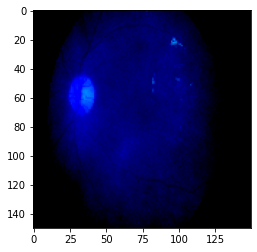

In [13]:
org_image =  cv2.imread("/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_002.jpg") # read all the images in the folder

org_image = cv2.resize(org_image, (z,y), interpolation=cv2.INTER_LINEAR)

h, w, c = org_image.shape
if (h < y) or (w < z):
  print(org_image.shape)
#org_image_gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
#cl1 = clahe.apply(org_image_gray)

#ret,thresh1 = cv2.threshold(cl1,60,180,cv2.THRESH_TOZERO)
#median = cv2.medianBlur(cl1,5)


#final_image = cv2.cvtColor(median, cv2.COLOR_BGR2RGB)  
final_image = (org_image / 127.5) - 1.0 

plt.imshow(final_image)

In [14]:
final_image1 = expand_dims(final_image, 0)
print(model.predict(final_image1))

[[0.8123954]]


In [15]:
explainer = lime.lime_image.LimeImageExplainer()
 
explanation = explainer.explain_instance(
    image=final_image,
    classifier_fn=model.predict,    
    top_labels = 1,
    hide_color=0,    
    num_samples=100)

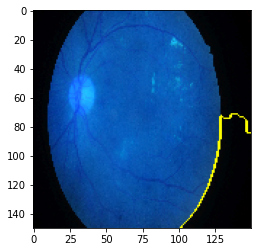

In [16]:
from skimage.segmentation import mark_boundaries
masked_image, boundaries = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=1, 
    hide_rest=False)
#plt.imshow(masked_image/ 2 + 0.5)
plt.imshow(mark_boundaries(final_image/ 2 + 0.5, boundaries))